In [1]:
#| default_exp training

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from urllib.request import urlretrieve
from torch import tensor,nn
import torch.nn.functional as F

In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

with gzip.open(path_gz, 'rb') as f: ((x_trn,y_trn),(x_val,y_val),_) = pickle.load(f, encoding='latin-1')
x_trn,y_trn, x_val,y_val = map(tensor, (x_trn,y_trn, x_val,y_val))

## Initial setup

### Data

In [4]:
n,m = x_trn.shape
c = y_trn.max()+1
nh = 50

In [5]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
    
    def forward(self, x):
        for l in self.layers: x = l(x)
        return x

In [6]:
model = Model(m, nh, 10)
pred = model(x_trn)
pred.shape

torch.Size([50000, 10])

### Cross entroy loss

In [7]:
def log_softmax(x): return (x.exp()/x.exp().sum(axis=-1, keepdim=True)).log()

In [8]:
log_softmax(pred)

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<LogBackward0>)

In [9]:
# simplifying with log(a/b) = log(a) - log(b)
def log_softmax(x): return x - x.exp().sum(axis=-1, keepdim=True).log()

In [10]:
log_softmax(pred)

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

**Anki: LogSumExp trick**

In [11]:
# todo: durchdenken
def logsumexp(x):
    m = x.max(-1)[0]  # Note Umer: [0] is required, because max returns 2 things: max value & argmax
    return m + (x-m[:,None]).exp().sum(-1).log()

In [12]:
def log_softmax(x): return x - x.logsumexp(-1, keepdim=True)

In [13]:
test_close(logsumexp(pred), pred.logsumexp(-1))
sm_pred = log_softmax(pred)
sm_pred

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

In [14]:
y_trn[:3]

tensor([5, 0, 4])

In [15]:
sm_pred[0,5], sm_pred[1,0], sm_pred[2,4]

(tensor(-2.20, grad_fn=<SelectBackward0>),
 tensor(-2.37, grad_fn=<SelectBackward0>),
 tensor(-2.36, grad_fn=<SelectBackward0>))

In [16]:
sm_pred[[0,1,2], y_trn[:3]]

tensor([-2.20, -2.37, -2.36], grad_fn=<IndexBackward0>)

Note Umer: You can pass list of indices for each dimension!

In [17]:
def nll(inp, target): return -inp[range(target.shape[0]), target].mean()

In [18]:
loss = nll(sm_pred, y_trn)
loss

tensor(2.30, grad_fn=<NegBackward0>)

In [19]:
test_close(F.nll_loss(F.log_softmax(pred, -1), y_trn), loss, 1e-3)

In [20]:
test_close(F.cross_entropy(pred, y_trn), loss, 1e-3)

### Basic training loop

In [21]:
loss_func = F.cross_entropy

In [22]:
bs=50  # batch size
xb = x_trn[:bs]  # a mini-batch from x
preds = model(xb) # predictions on that mini-batch
preds[0], preds.shape

(tensor([-0.09, -0.21, -0.08,  0.10, -0.04,  0.08, -0.04, -0.03,  0.01,  0.06], grad_fn=<SelectBackward0>),
 torch.Size([50, 10]))

In [23]:
yb = y_trn[:bs]
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
        3, 9, 8, 5, 9, 3])

In [24]:
loss_func(preds, yb)

tensor(2.30, grad_fn=<NllLossBackward0>)

In [25]:
preds.argmax(dim=1)

tensor([3, 9, 3, 8, 5, 9, 3, 9, 3, 9, 5, 3, 9, 9, 3, 9, 9, 5, 8, 7, 9, 5, 3, 8, 9, 5, 9, 5, 5, 9, 3, 5, 9, 7, 5, 7, 9, 9, 3, 9, 3, 5, 3, 8,
        3, 5, 9, 5, 9, 5])

In [26]:
#|export
def accuracy(out, yb): return (out.argmax(dim=1)==yb).float().mean()

In [27]:
accuracy(preds, yb)

tensor(0.08)

In [28]:
lr = 0.5  # learning rate
epochs = 3  # how many epochs to train for

In [29]:
#|export
def report(loss, preds, yb): print(f'{loss:.2f}, {accuracy(preds,yb):.2f}')

In [30]:
xb,yb = x_trn[:bs],y_trn[:bs]
preds = model(xb)
report(loss_func(preds,yb), preds, yb)

2.30, 0.08


In [31]:
for e in range(epochs):
    # for every mini-batch
    for i in range(0, n, bs):
        s = slice(i, i+bs)  # Note Umer: you can slice 'over the edge', ie min(..., last index) is handled automatically
        xb,yb = x_trn[s],y_trn[s]
    
        preds = model(xb)  # get preds   
        loss = loss_func(preds,yb)  # compute loss
        loss.backward()  # get gradients
        
        with torch.no_grad():
            # update 

            # Note Umer: model.parameters() is not recursive, ie only returns the direct parameters of Module
            # We therefore need to iterate tru layers and use those parameters
            #for p in model.parameters():
            #    p -= lr * p.grad
            #    p.grad.zero_()
            
            for l in model.layers:
                for p in l.parameters():
                    p -= lr*p.grad
                    p.grad.zero_()
                    
                # Note Umer: Jeremy instead checks if the layer has params via checking if a 'weight' attribute exists
                # if hasattr(l, 'weight'):
                #     l.weight -= l.weight.grad * lr
                #     l.bias   -= l.bias.grad   * lr
                #     l.weight.grad.zero_()
                #     l.bias  .grad.zero_()
                
    report(loss, preds, yb)

0.11, 0.96
0.13, 0.96
0.10, 0.96


Note Umer: Let's check if using .parameters() gives us all parameters, ie weights **and** biases

In [32]:
for l in model.layers:
    print(f'Layer {l}:')
    for i, p in enumerate(l.parameters()):
        print(f'- Param group {i} has shape {p.shape}')

Layer Linear(in_features=784, out_features=50, bias=True):
- Param group 0 has shape torch.Size([50, 784])
- Param group 1 has shape torch.Size([50])
Layer ReLU():
Layer Linear(in_features=50, out_features=10, bias=True):
- Param group 0 has shape torch.Size([10, 50])
- Param group 1 has shape torch.Size([10])


It does

### Using parameters and optim

#### Parameters

In [33]:
m1 = nn.Module()
m1.foo = nn.Linear(3,4)
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

In [34]:
list(m1.named_children())

[('foo', Linear(in_features=3, out_features=4, bias=True))]

In [35]:
list(m1.parameters())

[Parameter containing:
 tensor([[ 0.57,  0.43, -0.30],
         [ 0.13, -0.32, -0.24],
         [ 0.51,  0.04,  0.22],
         [ 0.13, -0.17, -0.24]], requires_grad=True),
 Parameter containing:
 tensor([-0.01, -0.51, -0.39,  0.56], requires_grad=True)]

In [36]:
class MLP(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        self.relu = nn.ReLU()
    
    def forward(self,x): return self.l2(self.relu(self.l1(x)))

In [37]:
model = MLP(m, nh, 10)
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [38]:
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [39]:
for name,l in model.named_children(): print(f'{name}: {l}')

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [40]:
for p in model.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [41]:
def fit():
    for epoch in range(epochs):
        for i in range(0,n,bs):
            s = slice(i,i+bs)
            xb,yb = x_trn[s],y_trn[s]
            preds = model(xb)
            loss = loss_func(preds,yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= lr*p.grad
                model.zero_grad()
        report(loss,preds,yb)

In [42]:
fit()

0.19, 0.96
0.11, 0.96
0.04, 1.00


In [43]:
class MyModule:
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
    
    def __setattr__(self,k,v):
        if not k.startswith('_'): self._modules[k] = v
        super().__setattr__(k,v)
    
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values(): yield from l.parameters()

In [44]:
mdl = MyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [45]:
for p in mdl.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


#### Registering modules

In [46]:
from functools import reduce

In [47]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [48]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
        
    def forward(self,x): return reduce(lambda val,layer: layer(val), self.layers, x)

In [49]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [50]:
model(xb).shape

torch.Size([50, 10])

### nn.ModuleList

In [51]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
    
    def forward(self,x):
        for l in self.layers: x=l(x)
        return x

In [52]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [53]:
fit()

0.12, 0.96
0.11, 0.96
0.07, 0.98


### nn.Sequential

In [54]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [55]:
fit()

0.16, 0.94
0.13, 0.96
0.08, 0.96


In [56]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

### optim

In [57]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr
    
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= self.lr*p.grad
    
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [58]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [59]:
opt = Optimizer(model.parameters())

In [60]:
for epoch in range(epochs):
    for i in range(0,n,bs):
        s = slice(i,i+bs)
        xb,yb = x_trn[s],y_trn[s]
        preds = model(xb)
        loss = loss_func(preds,yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.18, 0.94
0.13, 0.96
0.11, 0.94


In [61]:
from torch import optim

In [62]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [63]:
model,opt = get_model()
loss_func(model(xb),yb)

tensor(2.33, grad_fn=<NllLossBackward0>)

In [64]:
for epoch in range(epochs):
    for i in range(0,n,bs):
        s = slice(i,i+bs)
        xb,yb = x_trn[s],y_trn[s]
        preds = model(xb)
        loss = loss_func(preds,yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.12, 0.98
0.09, 0.98
0.07, 0.98


### Dataset and DataLoader

#### Dataset

In [65]:
#|export
class Dataset():
    def __init__(self,x,y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self,i): return self.x[i],self.y[i]

In [66]:
trn_ds,val_ds = Dataset(x_trn,y_trn),Dataset(x_val,y_val)
assert len(trn_ds)==len(x_trn)
assert len(val_ds)==len(x_val)

In [67]:
xb,yb = trn_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [68]:
model,opt = get_model()

In [69]:
for epoch in range(epochs):
    for i in range(0,n,bs):
        xb,yb = trn_ds[i:i+bs]
        preds = model(xb)
        loss = loss_func(preds,yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.17, 0.96
0.11, 0.94
0.09, 0.96


### DataLoader

In [70]:
class DataLoader():
    def __init__(self,ds,bs): self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0,len(self.ds),bs): yield self.ds[i:i+self.bs]

In [71]:
trn_dl = DataLoader(trn_ds, bs)
val_dl = DataLoader(val_ds, bs)

In [72]:
xb,yb = next(iter(trn_dl))
xb.shape

torch.Size([50, 784])

In [73]:
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
        3, 9, 8, 5, 9, 3])

tensor(5)

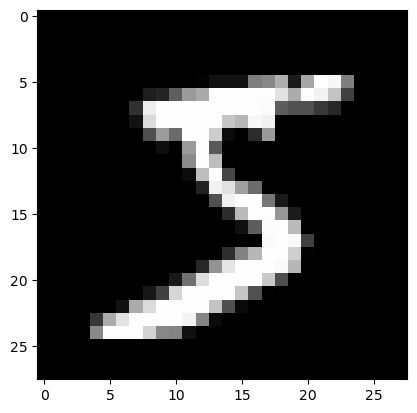

In [74]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [75]:
def fit():
    for epoch in range(epochs):
        for xb,yb in trn_dl:
            preds = model(xb)
            loss = loss_func(preds,yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, preds, yb)

In [76]:
fit()

0.08, 0.98
0.11, 0.98
0.07, 0.98


In [77]:
loss_func(model(xb),yb), accuracy(model(xb),yb)

(tensor(0.05, grad_fn=<NllLossBackward0>), tensor(0.98))

### Random sampling

In [78]:
import random

In [79]:
class Sampler():
    def __init__(self, ds, shuffle=False): self.n,self.shuffle=len(ds),shuffle
    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle: random.shuffle(res)
        return iter(res)

In [80]:
from itertools import islice

In [81]:
ss = Sampler(trn_ds)

In [82]:
it = iter(ss)

In [83]:
for _ in range(5): print(next(it))

0
1
2
3
4


In [84]:
list(islice(ss, 5))

[0, 1, 2, 3, 4]

In [85]:
ss = Sampler(trn_ds, shuffle=True)
list(islice(ss, 5))

[34492, 6248, 18963, 38212, 38261]

In [86]:
import fastcore.all as fc

In [87]:
class BatchSampler():
    def __init__(self, sampler, bs, drop_last=False): fc.store_attr()
    def __iter__(self): yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

In [88]:
batchs = BatchSampler(ss, 4)
list(islice(batchs,5))

[[12543, 22997, 9580, 39479],
 [49106, 27901, 45333, 31719],
 [10488, 37739, 17707, 30974],
 [41646, 38311, 31082, 4974],
 [6447, 21478, 28833, 38710]]

In [89]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

In [90]:
class DataLoader():
    def __init__(self, ds, batchs, collate_fn=collate): fc.store_attr()
    def __iter__(self): yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [91]:
trn_samp = BatchSampler(Sampler(trn_ds, shuffle=True), bs)
val_samp = BatchSampler(Sampler(val_ds, shuffle=False), bs)

In [92]:
trn_dl = DataLoader(trn_ds, trn_samp)
val_dl = DataLoader(val_ds, val_samp)

tensor(3)

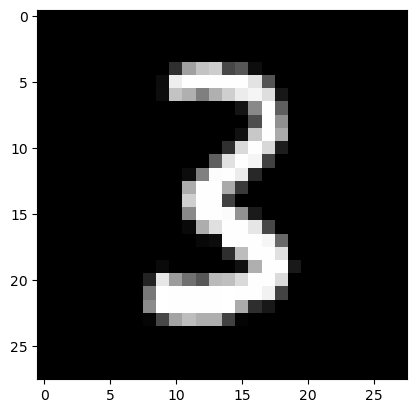

In [93]:
xb,yb = next(iter(val_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [94]:
xb.shape,yb.shape

(torch.Size([50, 784]), torch.Size([50]))

In [95]:
model,opt = get_model()

In [96]:
fit()

0.05, 0.98
0.10, 0.98
0.19, 0.90


### Multiprocessing DataLoader

In [97]:
import torch.multiprocessing as mp
from fastcore.basics import store_attr

In [98]:
trn_ds[[3,6,8,1]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [99]:
trn_ds.__getitem__([3,6,8,1])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [100]:
for o in map(trn_ds.__getitem__, ([3,6],[8,1])): print(o)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 1]))
(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 0]))


In [101]:
class DataLoader():
    def __init__(self, ds, batchs, n_workers=1, collate_fn=collate): store_attr()
    def __iter__(self):
        with mp.Pool(self.n_workers) as ex: yield from ex.map(self.ds.__getitem__, iter(self.batchs))

In [102]:
trn_dl = DataLoader(trn_ds, batchs=trn_samp, n_workers=2)
it = iter(trn_dl)

In [103]:
xb,yb = next(it)
xb.shape,yb.shape

(torch.Size([50, 784]), torch.Size([50]))

### PyTorch DataLoader

In [104]:
#|export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

In [105]:
trn_samp = BatchSampler(RandomSampler(trn_ds),     bs, drop_last=False)
val_samp = BatchSampler(SequentialSampler(val_ds), bs, drop_last=False)

In [106]:
trn_dl = DataLoader(trn_ds, batch_sampler=trn_samp, collate_fn=collate)
val_dl = DataLoader(val_ds, batch_sampler=val_samp, collate_fn=collate)

In [107]:
model,opt = get_model()
fit()
loss_func(model(xb),yb), accuracy(model(xb),yb)

0.11, 0.94
0.07, 0.98
0.04, 0.98


(tensor(0.04, grad_fn=<NllLossBackward0>), tensor(1.))

PyTorch can auto-generate the BatchSampler for us:

In [108]:
trn_dl = DataLoader(trn_ds, bs, sampler=RandomSampler(trn_ds), collate_fn=collate)
val_dl = DataLoader(val_ds, bs, sampler=SequentialSampler(val_ds), collate_fn=collate)

PyTorch can also generate the Sequential/RandomSamplers too:

In [109]:
trn_dl = DataLoader(trn_ds, bs, shuffle=True, drop_last=True, num_workers=2)
val_dl = DataLoader(val_ds, bs, shuffle=False, num_workers=2)

**Q:** Why set `drop_last=True` for `trn_dl`?

In [110]:
model,opt = get_model()
fit()
loss_func(model(xb),yb), accuracy(model(xb),yb)

0.12, 0.94
0.06, 0.96
0.13, 0.94


(tensor(0.06, grad_fn=<NllLossBackward0>), tensor(0.98))

Our dataset actually already knows how to sample a batch of indices all at once:

In [111]:
trn_ds[[4,5,6,7]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([9, 2, 1, 3]))

...that means we can actually skip the batch_sampler and collate_fn entirely: 

In [112]:
trn_dl = DataLoader(trn_ds, sampler=trn_samp)
val_dl = DataLoader(val_ds, sampler=val_samp)

Note Umer: above, we use a "normal" sampler (not a batch_sampler), that returns batch indices, which is okay, because are datasets can handle batch indices!

In [113]:
xb,yb = next(iter(trn_dl))
xb.shape,yb.shape

(torch.Size([1, 50, 784]), torch.Size([1, 50]))

### Validation

In [114]:
#|export
def fit(epochs, model, loss_func, opt, trn_dl, val_dl):
    for epoch in range(epochs):
        model.train()  # set model into train mode
        for xb,yb in trn_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        model.eval()  # set model into eval mode
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb,yb in val_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred,yb).item()*n
                tot_acc  += accuracy (pred,yb).item()*n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

In [115]:
#|export
def get_dls(trn_ds, val_ds, bs, **kwargs):
    return (DataLoader(trn_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(val_ds, batch_size=bs, **kwargs))

In [116]:
trn_dl,val_dl = get_dls(trn_ds,val_ds, bs)
model,opt = get_model()

In [117]:
%time loss,acc = fit(5, model, loss_func, opt, trn_dl, val_dl)

0 0.15938211173866876 0.9529000002145768
1 0.12813598544569685 0.9622999989986419
2 0.11384969513106626 0.9677000015974044
3 0.12173387734859716 0.9652000015974045
4 0.10598109507525805 0.9720000013709068
CPU times: user 7.02 s, sys: 22 ms, total: 7.04 s
Wall time: 7.09 s
